In [1]:
from collections import Counter
from functools import lru_cache

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pylab as plt
from scipy.stats import linregress

from dotless_arabic.processing import process,undot

from dotless_arabic.datasets.news.collect import collect_raw_dataset as collect_raw_news_dataset
from dotless_arabic.datasets.quran.collect import collect_raw_dataset as collect_raw_quran_dataset
from dotless_arabic.datasets.poems.collect import collect_raw_dataset as collect_raw_poems_dataset
from dotless_arabic.datasets.wikipedia.collect import collect_raw_dataset as collect_raw_wikipedia_dataset
from dotless_arabic.datasets.sanadset_hadeeth.collect import collect_raw_dataset as collect_raw_hadeeth_dataset

# functions

In [2]:
@lru_cache()
def characters_counter(dataset):
  return Counter(character for item in dataset for character in list(item))

@lru_cache()
def words_counter(dataset):
  return Counter(word for item in dataset for word in item.split())

In [3]:
def get_zipf_constants(dataset):
    counter = words_counter(tuple(dataset))
    heighest_frequency = counter.most_common(1)[0][1]
    X = np.log(heighest_frequency) * np.log((np.arange(len(counter)) + 1))
    Y = np.log(np.array(list(counter.values())))
    slope, intercept, *_ = linregress(X, Y)
    return np.exp(slope), np.exp(intercept)


In [4]:
poems = list()
for poem in tqdm(collect_raw_poems_dataset()['poem verses']):
    poems.extend(poem)
poems = list(set(poems))

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/magedsaeed/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/254630 [00:00<?, ?it/s]

In [5]:
datasets = [
    list(map(process,tqdm(collect_raw_quran_dataset()))),
    list(map(process,tqdm(collect_raw_hadeeth_dataset()))),
    # list(map(process,tqdm(poems))),
    # collect_raw_wikipedia_dataset,
    # collect_raw_news_dataset
]
datasets_names = [
    'quran',
    'sanadset hadeeth',
    # 'poems',
    # 'wikipedia',
    # 'news',
]

  0%|          | 0/6236 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


  0%|          | 0/637565 [00:00<?, ?it/s]

In [16]:
def plot_zipf(figsize=(12, 10), top_words=1000):
    # https://github.com/MagedSaeed/zipfs_law
    def _plot(counter, name, axis, log):
        frequencies = [
            item[1]
            for item in sorted(counter.items(), key=lambda item: item[1], reverse=True)
        ][:top_words]
        ranks = [
            item + 1
            for item in range(
                len(sorted(counter.items(), key=lambda item: item[1], reverse=True))
            )
        ][:top_words]
        axis.plot(ranks, frequencies, label=name)

        if log:
            axis.set_xscale("log")
            axis.set_yscale("log")

        # add axis labels, title, and legend
        # axis.xlabel('Rank')
        # axis.ylabel('Frequency')
        title = "Frequency vs Rank for Words in a Text"
        if log:
            title = "Logorithmic " + title
        axis.set_title(title)
        axis.legend(loc="upper right")

    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    for dataset,dataset_name in zip(datasets,datasets_names):
        
        undotted_dataset = list(map(undot, dataset))
        dotted_counter = words_counter(dataset=tuple(dataset))
        undotted_counter = words_counter(dataset=tuple(undotted_dataset))
        highest_frequency_dotted = dotted_counter.most_common(1)[0][1]
        alpha_dotted, c_dotted = get_zipf_constants(dataset)
        
        # _plot(
        #     counter=dotted_counter,
        #     name=dataset_name + " dataset",
        #     axis=axis,
        #     log=False,
        # )
        # _plot(
        #     counter=undotted_counter,
        #     name="undotted " + dataset_name + " dataset",
        #     axis=axis,
        #     log=False,
        # )
        
        # _plot(
        #     counter={
        #         # rank:heighest_frequency*(1/rank)
        #         # rank:  freqs_sum / c * rank **(-alpha) # use the estimated zipf's values
        #         rank: highest_frequency_dotted / (rank**-alpha_dotted)
        #         for rank, frequency in enumerate(
        #             sorted(
        #                 dotted_counter.values(),
        #                 reverse=True,
        #             ),
        #             start=1,
        #         )
        #     },
        #     name="standard zipfian distribution for dotted dataset",
        #     axis=axis,
        #     log=False,
        # )
        # logarithmic
        _plot(
            counter=dotted_counter,
            name=dataset_name,
            axis=axis,
            log=True,
        )
        _plot(
            counter=undotted_counter,
            name="undotted " + dataset_name,
            axis=axis,
            log=True,
        )
        _plot(
            counter={
                # rank:heighest_frequency*(1/rank) # use the estimated zipf's values
                # rank:  freqs_sum / c * rank **(-alpha) # use the estimated zipf's values
                rank: highest_frequency_dotted / (rank**alpha_dotted)
                for rank, frequency in enumerate(
                    sorted(
                        dotted_counter.values(),
                        reverse=True,
                    ),
                    start=1,
                )
            },
            name=f"standard zipfian distribution for dotted {dataset_name}",
            axis=axis,
            log=True,
        )


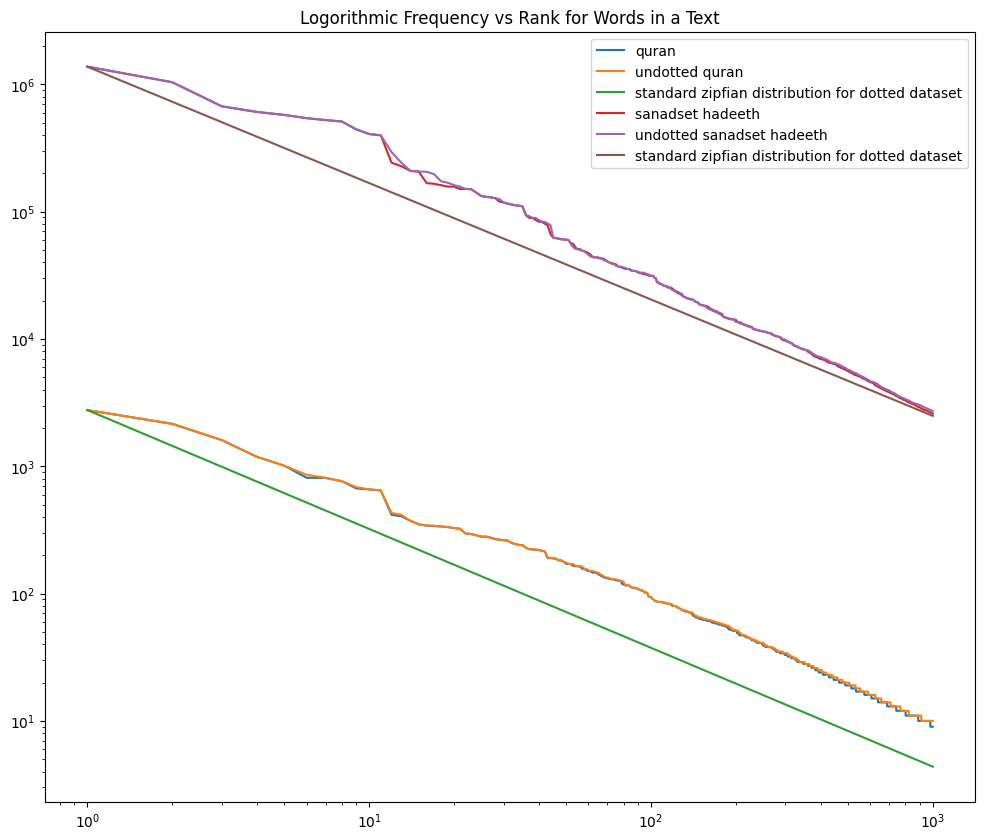

In [17]:
plot_zipf()